In [7]:
Ux = np.random.default_rng().uniform(low=-15, high=15, size=500)
Uy = np.random.default_rng().uniform(low=-15, high=15, size=500)
Uz = np.random.default_rng().uniform(low=-15, high=15, size=500)

In [125]:
def calc_max_covariance(self, df: pd.DataFrame, colx: str, coly: str, lags: int = 10) -> [float, int]:
    """
    Find maximum covariance between two variables
    :param df: Pandas DataFrame containing the data
    :param colx: DataFrame column with x variable
    :param coly: DataFrame column with y variable
    :param lags: number of lags to search over; default is 10; larger number requires more time
    :return: maximum covariance between two variables, lag number of max covariance
    """
    dfcov = []
    for i in np.arange(-1 * lags, lags):
        df[f"{coly}_{i}"] = df[coly].shift(i)
        dfcov.append(df[[colx, f"{coly}_{i}"]].cov().loc[colx, f"{coly}_{i}"])
        # print(i,df[[colx, f"{coly}_{i}"]].cov().loc[colx, f"{coly}_{i}"])
        df = df.drop([f"{coly}_{i}"], axis=1)

    abscov = np.abs(dfcov)
    maxabscov = np.max(abscov)
    try:
        maxlagindex = np.where(abscov == maxabscov)[0][0]
        lagno = maxlagindex - lags
        maxcov = dfcov[maxlagindex]
    except IndexError:
        lagno = 0
        maxcov = dfcov[10]
    return maxcov, lagno

[[0.50206128 0.00056297]
 [0.00056297 0.49792026]]


array([4.17732163e+05, 4.63978680e-27])

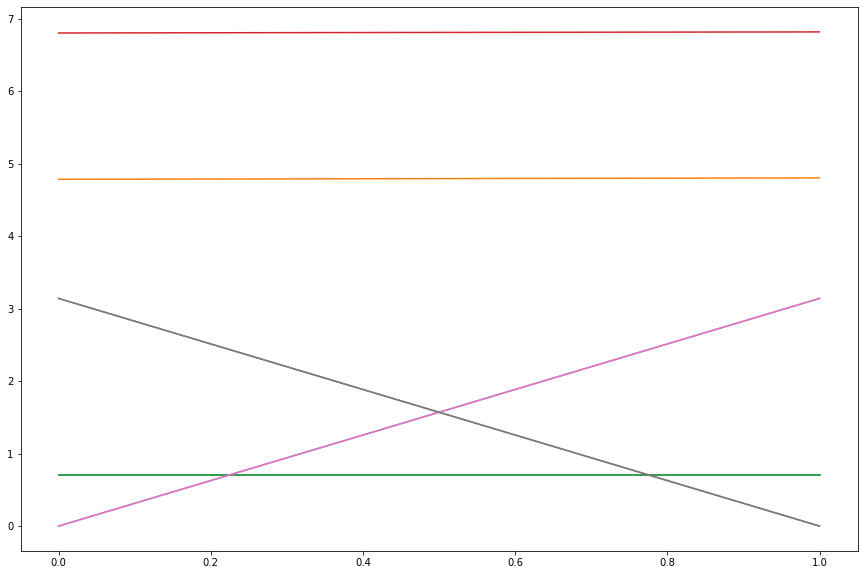

In [100]:
data = np.linspace(0,50,1000)
x = np.sin(data)
y = np.cos(data)

#plt.plot(data, x)
#plt.plot(data, y)

print(np.cov(x,y,bias=True))

mca = MCA(np.stack([data,x], axis=1), np.stack([data,y], axis=1))
mca.solve(complexify=True,period=100)
#plt.plot(mca.temporal_amplitude()['left'])
#plt.plot(mca.temporal_amplitude()['right'])
plt.plot(mca.temporal_phase()['left'])
#plt.plot(mca.temporal_phase()['right'])
mca.singular_values(n=100)

In [74]:
mca.correlation_matrix()

array([[1., 0.],
       [0., 1.]])

In [133]:
Ux = np.random.default_rng().uniform(low=-15, high=15, size=500)
Uy = np.random.default_rng().uniform(low=-15, high=15, size=500)
Uz = np.random.default_rng().uniform(low=-15, high=15, size=500)

In [140]:
from numba import njit, prange
import numpy as np

@njit(parallel=True)
def shadow_correction(Ux, Uy, Uz):
    """Correction for flow distortion of CSAT sonic anemometer from Horst and others (2015) based on work by Kaimal

    :param Ux: Longitudinal component of the wind velocity (m s-1); aka u
    :param Uy: Lateral component of the wind velocity (m s-1); aka v
    :param Uz: Vertical component of the wind velocity (m s-1); aka w
    :return: corrected wind components
    """

    # Rotation Matrix to Align with Path Coordinate System of Transducers
    h = [0.25, 0.4330127018922193, 0.8660254037844386,
         -0.5, 0.0, 0.8660254037844386,
         0.25, -0.4330127018922193, 0.8660254037844386]

    # Inverse of the Rotation Matrix
    hinv = [0.6666666666666666, -1.3333333333333333, 0.6666666666666666,
            1.1547005383792517, 0.0, -1.1547005383792517,
            0.38490017945975047, 0.38490017945975047, 0.38490017945975047]

    iteration = 0

    while iteration < 4:

        Uxh = h[0] * Ux + h[1] * Uy + h[2] * Uz
        Uyh = h[3] * Ux + h[4] * Uy + h[5] * Uz
        Uzh = h[6] * Ux + h[7] * Uy + h[8] * Uz

        scalar = np.sqrt(Ux ** 2. + Uy ** 2. + Uz ** 2.)

        Theta1 = np.arccos(np.abs(h[0] * Ux + h[1] * Uy + h[2] * Uz) / scalar)
        Theta2 = np.arccos(np.abs(h[3] * Ux + h[4] * Uy + h[5] * Uz) / scalar)
        Theta3 = np.arccos(np.abs(h[6] * Ux + h[7] * Uy + h[8] * Uz) / scalar)

        #  Adjustment Factors for Each Component
        # Adjust for the Shadowing Effects

        Uxa = Uxh / (0.84 + 0.16 * np.sin(Theta1))
        Uya = Uyh / (0.84 + 0.16 * np.sin(Theta2))
        Uza = Uzh / (0.84 + 0.16 * np.sin(Theta3))

        # Transform the Winds Components Back to the CSAT Coordinate System.
        # These are the Corrected Velocities.

        Uxc = hinv[0] * Uxa + hinv[1] * Uya + hinv[2] * Uza
        Uyc = hinv[3] * Uxa + hinv[4] * Uya + hinv[5] * Uza
        Uzc = hinv[6] * Uxa + hinv[7] * Uya + hinv[8] * Uza

        Ux = Uxc
        Uy = Uyc
        Uz = Uzc

        iteration += 1

    return Uxc, Uyc, Uzc

%timeit shadow_correction(Ux, Uy, Uz)
shadow_correction(Ux, Uy, Uz)

107 µs ± 35.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


(array([ 2.34978217e+01, -1.30572051e+01, -1.46959553e+01, -1.07457178e+01,
        -9.99833990e+00, -6.52970948e+00,  7.06303611e+00, -6.88393783e+00,
         2.25556314e+01, -6.38985782e+00, -1.06177966e+01, -1.14933747e+01,
         4.20228257e+00,  1.38938752e+00,  5.84169737e+00,  2.42844611e+00,
         7.64163879e+00,  1.39194579e+01,  1.77676596e+01, -1.64083233e+01,
        -1.02105077e+00, -8.53262059e+00,  1.68796653e+01,  1.38894306e+01,
         1.91617737e+01, -1.32232174e+01,  6.17681183e+00, -1.35420561e+01,
         1.00627359e+01,  4.92485798e-01, -3.40582355e+00, -1.20613003e+01,
        -1.00476488e+01,  1.98305642e+00,  1.82574332e+01,  1.74133771e+01,
         1.55567967e+01, -7.83271200e+00,  1.71630814e+01,  2.47717165e+01,
         1.23827286e+01,  1.30635422e+01,  6.94583592e+00, -1.63793029e+01,
         1.10373124e+01, -1.17694313e+01,  2.99304267e+00, -1.25473253e+01,
        -6.24551384e+00,  1.35071602e+01,  9.56552196e+00, -8.70514150e+00,
         7.2

In [128]:
from numba import jit, int32

@jit
def shadow_correction(Ux, Uy, Uz):
    
    # Rotation Matrix to Align with Path Coordinate System of Transducers
    h = [0.25, 0.4330127018922193, 0.8660254037844386, 
                  -0.5, 0.0, 0.8660254037844386, 
                  0.25, -0.4330127018922193, 0.8660254037844386]

    # Inverse of the Rotation Matrix
    hinv = [0.6666666666666666, -1.3333333333333333, 0.6666666666666666, 
                  1.1547005383792517, 0.0, -1.1547005383792517, 
                  0.38490017945975047, 0.38490017945975047, 0.38490017945975047]


    Uxh = h[0]*Ux + h[1]*Uy + h[2]*Uz
    Uyh = h[3]*Ux + h[4]*Uy + h[5]*Uz
    Uzh = h[6]*Ux + h[7]*Uy + h[8]*Uz

    scalar = np.sqrt(Ux ** 2. + Uy ** 2. + Uz ** 2.)

    Theta1 = np.arccos(np.abs(h[0]*Ux + h[1]*Uy + h[2]*Uz) / scalar)
    Theta2 = np.arccos(np.abs(h[3]*Ux + h[4]*Uy + h[5]*Uz) / scalar)
    Theta3 = np.arccos(np.abs(h[6]*Ux + h[7]*Uy + h[8]*Uz) / scalar)

    #  Adjustment Factors for Each Component

    c1 = 1. / (0.84 + 0.16*np.sin(Theta1))
    c2 = 1. / (0.84 + 0.16*np.sin(Theta2))
    c3 = 1. / (0.84 + 0.16*np.sin(Theta3))

    # Adjust for the Shadowing Effects

    Uxa=Uxh*c1
    Uya=Uyh*c2
    Uza=Uzh*c3

    # Transform the Winds Components Back to the CSAT Coordinate System.
    # These are the Corrected Velocities.

    Uxc = hinv[0]*Uxa + hinv[1]*Uya + hinv[2]*Uza
    Uyc = hinv[3]*Uxa + hinv[4]*Uya + hinv[5]*Uza
    Uzc = hinv[6]*Uxa + hinv[7]*Uya + hinv[8]*Uza

    return Uxc, Uyc, Uzc
#Uxx=Uxc
#Uyy=Uyc
#Uzz=Uzc
%timeit shadow_correction(Ux, Uy, Uz)
shadow_correction(Ux, Uy, Uz)

35.9 µs ± 8.87 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


(array([-1.13346286e+01, -1.08524786e+01,  1.07421552e+01,  1.50875518e+01,
         1.29128331e+01, -7.38928867e+00, -1.35603135e+01,  1.33344004e+01,
         1.47649998e+01,  9.83424083e+00,  1.47514489e+01, -9.30694364e+00,
         1.37015961e+01, -2.76895892e+00,  2.75378488e-01,  1.37330405e+01,
         6.17791653e+00,  1.31801880e+01, -3.79532939e+00, -8.46127850e+00,
        -1.45816832e+01, -1.02934955e+01, -1.16819113e+01, -4.47803658e+00,
         1.42661031e+01, -1.16268940e+01,  3.38368624e+00, -1.25605266e+01,
         6.01353635e+00,  5.82955722e+00,  2.44577880e-01, -1.53652620e+01,
         8.28130566e-01,  4.01535931e+00,  1.29268556e+01,  7.51327976e-01,
         1.55197122e+01, -5.87518732e+00,  4.54746595e+00,  4.37185528e+00,
        -1.49743631e+01, -1.51221495e+01, -7.26944294e+00, -1.20327649e+00,
         9.16382224e+00, -7.23129207e+00, -1.29574696e+01, -1.01417865e+01,
         1.27568379e+01, -6.94164246e-02, -6.24236550e+00, -1.56008698e+01,
        -6.2

In [33]:
https://link.springer.com/article/10.1007/s10546-015-0010-3

@jit
def shadow_correction(Ux, Uy, Uz):
    
    # Rotation Matrix to Align with Path Coordinate System of Transducers
    h = [0.25, 0.4330127018922193, 0.8660254037844386, 
                  -0.5, 0.0, 0.8660254037844386, 
                  0.25, -0.4330127018922193, 0.8660254037844386]

    # Inverse of the Rotation Matrix
    hinv = [0.6666666666666666, -1.3333333333333333, 0.6666666666666666, 
                  1.1547005383792517, 0.0, -1.1547005383792517, 
                  0.38490017945975047, 0.38490017945975047, 0.38490017945975047]


    Uxh = h[0]*Ux + h[1]*Uy + h[2]*Uz
    Uyh = h[3]*Ux + h[4]*Uy + h[5]*Uz
    Uzh = h[6]*Ux + h[7]*Uy + h[8]*Uz

    scalar = np.sqrt(Ux ** 2. + Uy ** 2. + Uz ** 2.)

    Theta1 = np.arccos(np.abs(h[0]*Ux + h[1]*Uy + h[2]*Uz) / scalar)
    Theta2 = np.arccos(np.abs(h[3]*Ux + h[4]*Uy + h[5]*Uz) / scalar)
    Theta3 = np.arccos(np.abs(h[6]*Ux + h[7]*Uy + h[8]*Uz) / scalar)

    #  Adjustment Factors for Each Component
    # Adjust for the Shadowing Effects

    Uxa = Uxh / (0.84 + 0.16*np.sin(Theta1))
    Uya = Uyh / (0.84 + 0.16*np.sin(Theta2))
    Uza = Uzh / (0.84 + 0.16*np.sin(Theta3))

    # Transform the Winds Components Back to the CSAT Coordinate System.
    # These are the Corrected Velocities.

    Uxc = hinv[0]*Uxa + hinv[1]*Uya + hinv[2]*Uza
    Uyc = hinv[3]*Uxa + hinv[4]*Uya + hinv[5]*Uza
    Uzc = hinv[6]*Uxa + hinv[7]*Uya + hinv[8]*Uza

    return Uxc, Uyc, Uzc
#Uxx=Uxc
#Uyy=Uyc
#Uzz=Uzc
shadow_correction(Ux, Uy, Uz)

(array([ -0.47230663,   4.04440555, -13.01763374,  -0.48707961,
        -10.84765835, -13.66351046,   8.53340037,  15.30937838,
         -0.87083089, -15.50730908,   0.6422647 , -12.03799199,
         -0.2342539 ,  16.66607532,  14.30513978,  -4.49356778,
         18.58914071, -10.47011938,  14.92624642,  12.12266661,
        -16.45583765,  13.76114933, -18.06836804,  -9.09335416,
         16.81977089,   1.40085352,  -0.36660884,  11.2111327 ,
          6.03342466,  -2.26077618, -15.19270186,  15.72861662,
          3.82829845, -12.82379761,  11.84436223,  -3.43270103,
         21.27337584, -13.27566028,   6.06015916, -11.0326607 ,
         16.62681072,  17.24345792,   5.21108157,  13.97375127,
          1.39165513,  15.2375848 ,  -4.93000709,   4.07459526,
         -2.86095199,  -8.51970161, -14.5089328 ,  12.06170504,
          4.30216238, -15.07155111,  -1.60516554,   9.16945543,
         -9.73522411, -10.87833013,  15.30641062, -14.45283551,
         13.28961458,  -2.79979018,  -4.

In [28]:
def fix_csat(Ux, Uy, Uz):

    CSAT3Inverse = [[-0.5, 0, 0.8660254037844386],
                    [0.25, 0.4330127018922193, 0.8660254037844386],
                    [0.25, -0.4330127018922193, 0.8660254037844386]]
    CSAT3Transform = [[-1.3333333333333, 0.66666666666666, 0.66666666666666],
                      [0, 1.1547005383792, -1.1547005383792],
                      [0.3849001794597, 0.3849001794597, 0.3849001794597]]

    u = {}
    u[0] = CSAT3Inverse[0][0] * Ux + CSAT3Inverse[0][1] * Uy + CSAT3Inverse[0][2] * Uz
    u[1] = CSAT3Inverse[1][0] * Ux + CSAT3Inverse[1][1] * Uy + CSAT3Inverse[1][2] * Uz
    u[2] = CSAT3Inverse[2][0] * Ux + CSAT3Inverse[2][1] * Uy + CSAT3Inverse[2][2] * Uz

    scalar = (Ux ** 2. + Uy ** 2. + Uz ** 2.) ** 0.5

    u[0] = u[0] / (0.68 + 0.32 * np.sin(np.arccos(u[0] / scalar)))
    u[1] = u[1] / (0.68 + 0.32 * np.sin(np.arccos(u[1] / scalar)))
    u[2] = u[2] / (0.68 + 0.32 * np.sin(np.arccos(u[2] / scalar)))

    Ux_out = CSAT3Transform[0][0] * u[0] + CSAT3Transform[0][1] * u[1] + CSAT3Transform[0][2] * u[2]
    Uy_out = CSAT3Transform[1][0] * u[0] + CSAT3Transform[1][1] * u[1] + CSAT3Transform[1][2] * u[2]
    Uz_out = CSAT3Transform[2][0] * u[0] + CSAT3Transform[2][1] * u[1] + CSAT3Transform[2][2] * u[2]

    return Ux_out, Uy_out, Uz_out

fix_csat(Ux, Uy, Uz)

(array([ -0.47230663,   4.04440555, -13.01763374,  -0.48707961,
        -10.84765835, -13.66351046,   8.53340037,  15.30937838,
         -0.87083089, -15.50730908,   0.6422647 , -12.03799199,
         -0.2342539 ,  16.66607532,  14.30513978,  -4.49356778,
         18.58914071, -10.47011938,  14.92624642,  12.12266661,
        -16.45583765,  13.76114933, -18.06836804,  -9.09335416,
         16.81977089,   1.40085352,  -0.36660884,  11.2111327 ,
          6.03342466,  -2.26077618, -15.19270186,  15.72861662,
          3.82829845, -12.82379761,  11.84436223,  -3.43270103,
         21.27337584, -13.27566028,   6.06015916, -11.0326607 ,
         16.62681072,  17.24345792,   5.21108157,  13.97375127,
          1.39165513,  15.2375848 ,  -4.93000709,   4.07459526,
         -2.86095199,  -8.51970161, -14.5089328 ,  12.06170504,
          4.30216238, -15.07155111,  -1.60516554,   9.16945543,
         -9.73522411, -10.87833013,  15.30641062, -14.45283551,
         13.28961458,  -2.79979018,  -4.

In [29]:
#@numba.njit#(forceobj=True)
def fix_csat(Ux, Uy, Uz):

    CSAT3Inverse = [[-0.5, 0, 0.8660254037844386],
                    [0.25, 0.4330127018922193, 0.8660254037844386],
                    [0.25, -0.4330127018922193, 0.8660254037844386]]
    CSAT3Transform = [[-1.3333333333333, 0.66666666666666, 0.66666666666666],
                      [0, 1.1547005383792, -1.1547005383792],
                      [0.3849001794597, 0.3849001794597, 0.3849001794597]]

    Ux_out = []
    Uy_out = []
    Uz_out = []

    for i in range(len(Ux)):
        u = {}
        u[0] = CSAT3Inverse[0][0] * Ux[i] + CSAT3Inverse[0][1] * Uy[i] + CSAT3Inverse[0][2] * Uz[i]
        u[1] = CSAT3Inverse[1][0] * Ux[i] + CSAT3Inverse[1][1] * Uy[i] + CSAT3Inverse[1][2] * Uz[i]
        u[2] = CSAT3Inverse[2][0] * Ux[i] + CSAT3Inverse[2][1] * Uy[i] + CSAT3Inverse[2][2] * Uz[i]

        scalar = (Ux[i] ** 2. + Uy[i] ** 2. + Uz[i] ** 2.) ** 0.5

        u[0] = u[0] / (0.68 + 0.32 * np.sin(np.arccos(u[0] / scalar)))
        u[1] = u[1] / (0.68 + 0.32 * np.sin(np.arccos(u[1] / scalar)))
        u[2] = u[2] / (0.68 + 0.32 * np.sin(np.arccos(u[2] / scalar)))

        Ux_out.append(CSAT3Transform[0][0] * u[0] + CSAT3Transform[0][1] * u[1] + CSAT3Transform[0][2] * u[2])
        Uy_out.append(CSAT3Transform[1][0] * u[0] + CSAT3Transform[1][1] * u[1] + CSAT3Transform[1][2] * u[2])
        Uz_out.append(CSAT3Transform[2][0] * u[0] + CSAT3Transform[2][1] * u[1] + CSAT3Transform[2][2] * u[2])

    return Ux_out, Uy_out, Uz_out

fix_csat(Ux, Uy, Uz)

([-0.47230663130838707,
  4.0444055451347785,
  -13.017633743343861,
  -0.48707961336295535,
  -10.84765834609271,
  -13.66351046419702,
  8.53340036842573,
  15.309378376913154,
  -0.8708308893295609,
  -15.507309084731062,
  0.6422647012442884,
  -12.037991988457092,
  -0.2342539001080599,
  16.66607532070794,
  14.305139776748495,
  -4.4935677828730896,
  18.58914070835075,
  -10.470119376097767,
  14.926246421614055,
  12.1226666130714,
  -16.45583764943764,
  13.76114932999211,
  -18.06836804166438,
  -9.093354160266568,
  16.819770892935907,
  1.4008535247809784,
  -0.36660884023175644,
  11.21113269824902,
  6.033424660306807,
  -2.2607761776525974,
  -15.192701859591526,
  15.72861662237651,
  3.8282984522224393,
  -12.823797605685083,
  11.844362233340686,
  -3.4327010348259392,
  21.273375835348165,
  -13.275660276461554,
  6.060159160782625,
  -11.032660697640704,
  16.626810724619205,
  17.243457923748263,
  5.211081566609812,
  13.973751267063077,
  1.3916551320276094,
  1

In [24]:
def calc_Td(E):
    """
    Dew point equation
    :param E: Water vapour pressure at saturation
    :return:
    """
    c0 = 207.98233
    c1 = -20.156028
    c2 = 0.46778925
    c3 = -0.0000092288067
    d0 = 1
    d1 = -0.13319669
    d2 = 0.0056577518
    d3 = -0.000075172865
    lne = np.log(E)
    return (c0 + c1 * lne + c2 * lne ** 2 + c3 * lne ** 3) / (d0 + d1 * lne + d2 * lne ** 2 + d3 * lne ** 3)

def calc_Q(P, E):
    return (0.622 * E) / (P - 0.378 * E)

def calc_E(pV, T, Rv):
    return pV * Rv * T

def calc_L(Ust, Tsa, Uz_Ta):
    #removed negative sign
    return -1*(Ust ** 3) * Tsa / (9.8 * 0.4 * Uz_Ta)

#@numba.njit#(forceobj=True)
def calc_Tsa(Ts, P, pV, Rv=461.51):
    """
    Calculate the average sonic temperature
    :param Ts:
    :param P:
    :param pV:
    :param Rv:
    :return:
    """
    E = pV * Rv * Ts
    return -0.01645278052 * (
                -500 * P - 189 * E + np.sqrt(250000 * P ** 2 + 128220 * E * P + 35721 * E ** 2)) / pV / Rv


#@numba.njit#(forceobj=True)
def tetens(t, a=0.611, b=17.502, c=240.97):
    """Tetens formula for computing the
    saturation vapor pressure of water from temperature; eq. 3.8

    :param t: temperature (C)
    :param a: constant (kPa)
    :param b: constant (dimensionless)
    :param c: constant (C)
    :return: saturation vapor pressure (kPa)
    """
    return a * np.exp((b * t) / (t + c))

def convert_CtoK(T):
    """
    Convert Celcius to Kelvin
    :param T: Temperature in Celcius degrees
    :return: Temperature in Kelvin
    """
    return T + 273.16

#@numba.jit(forceobj=True)
def calc_Es(T: float) -> float:
    """
    Saturation Vapor Pressure Equation
    :param T: Water temperature in Celcius
    :return: Saturation Vapor Pressure (Pa)
    """
    g0 = -2836.5744
    g1 = -6028.076559
    g2 = 19.54263612
    g3 = -0.02737830188
    g4 = 0.000016261698
    g5 = 0.00000000070229056
    g6 = -0.00000000000018680009
    g7 = 2.7150305
    
    T = convert_CtoK(T)
    return np.exp(
        g0 * T ** (-2) + g1 * T ** (-1) + g2 + g3 * T + g4 * T ** 2 + g5 * T ** 3 + g6 * T ** 4 + g7 * np.log(T))

In [23]:
print(tetens(15))
print(calc_Es(15))

1.7039850986941583
1706.82173176024


In [10]:
from dataclasses import dataclass, field

In [14]:
class Constants:
    c0: float = 207.98233
    c1: float = -20.156028
    c2: float = 0.46778925
    c3: float = -0.0000092288067
    d0: float = 1
    d1: float = -0.13319669
    d2: float = 0.0056577518
    d3: float = -0.000075172865
        
    g0: float = -2836.5744
    g1: float = -6028.076559
    g2: float = 19.54263612
    g3: float = -0.02737830188
    g4: float = 0.000016261698
    g5: float = 0.00000000070229056
    g6: float = -0.00000000000018680009
    g7: float = 2.7150305



In [15]:
const = Constants()
const.g0

-2836.5744